In [12]:
from pympi import Praat
import json
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from tqdm import tqdm

import sys
project_root = r'C:\projects\malachor5'
os.chdir(project_root)
sys.path.append('scripts')
from kws import get_sliding_window

# Load data
Load forced-aligned TextGrids and KWS probabilities.

In [13]:
textgrid_dir = r'C:\projects\malachor5\data\tira_eval_mfa_aligned'
kws_out_dir = r'C:\projects\malachor5\data\tira_eval_kws'

In [14]:
tg_paths = glob(os.path.join(textgrid_dir, '*.TextGrid'))
tg_paths

['C:\\projects\\malachor5\\data\\tira_eval_mfa_aligned\\HH20210312.TextGrid',
 'C:\\projects\\malachor5\\data\\tira_eval_mfa_aligned\\HH20210913.TextGrid',
 'C:\\projects\\malachor5\\data\\tira_eval_mfa_aligned\\HH20220327-2.TextGrid']

In [15]:
json_paths = glob(os.path.join(kws_out_dir, '*.json'))
json_paths

['C:\\projects\\malachor5\\data\\tira_eval_kws\\HH20210312.json',
 'C:\\projects\\malachor5\\data\\tira_eval_kws\\HH20210913.json',
 'C:\\projects\\malachor5\\data\\tira_eval_kws\\HH20220327-2.json']

# Keyword search / ground truth correlation
How close do the KWS probabilities from CLAP-IPA correlate to the ground truth timestamps of the given word?

Getting the KWS probabilities into vector form is easy: just index the column from the matrix.

In [16]:
with open(json_paths[0], encoding='utf8') as f:
    kws_json = json.load(f)
keywords = kws_json['keywords']
timestamps = kws_json['timestamps']
sim_mat = kws_json['similarity_matrix']
sim_mat = np.array(sim_mat)
sim_mat.shape, len(keywords), len(timestamps)

((5329, 18), 18, 5329)

Ground truth vectors will require some more querying: get all intervals at a given timepoint and check if the interval value corresponds to the keyword or a word within the keyword.

`pympi` doesn't allow direct querying of intervals, so first let's make a dataframe from the textgrid.

In [17]:
def textgrid_to_df(textgrid_path):
    tg = Praat.TextGrid(textgrid_path)
    rows = []
    for tier in tg.get_tiers():
        if 'words' not in tier.name:
            continue
        speaker = tier.name.split()[0]
        for start, end, val in tier.get_all_intervals():
            rows.append({
                'start': start,
                'end': end,
                'text': val,
                'speaker': speaker
            })
    return pd.DataFrame(rows)
df=textgrid_to_df(tg_paths[0])
df.head()

,start,end,text,speaker
0,0.00,0.45,,HIM
1,0.45,0.98,hello,HIM
2,0.98,1.33,hello,HIM
3,1.33,1.66,hello,HIM
4,1.66,1.69,oh,HIM


Then write a function to find all timestamps from a list that are hits for a given keyword.

In [18]:
def is_keyword_hit(df, keyword, midpoint):
    midpoint_mask = (df['start']<=midpoint) & (df['end']>=midpoint)
    keyword_mask = df['text'].isin(keyword.split())
    return 1 if (midpoint_mask & keyword_mask).sum() > 0 else 0

def get_midpoints(timestamps):
    return [(timestamp['end_s']+timestamp['start_s'])/2 for timestamp in timestamps]

def timestamp_hits(df, keyword, timestamps):
    midpoints = get_midpoints(timestamps)
    return np.array([is_keyword_hit(df, keyword, t) for t in midpoints])

hits = timestamp_hits(df, keywords[0], timestamps)

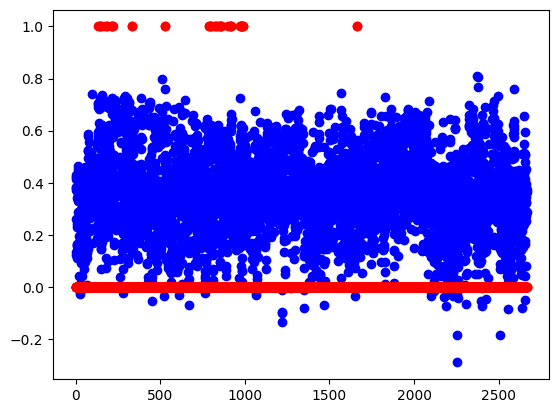

In [19]:
i = 0
kw_probs = sim_mat[:,i]
ground_truth = timestamp_hits(df, keywords[i], timestamps)
midpoints = get_midpoints(timestamps)

plt.scatter(midpoints, kw_probs, c='blue')
plt.scatter(midpoints, ground_truth, c='red')
plt.show()


# EER
Plot the ROC curve and write a function to get the Equal Error Rate for keyword detection

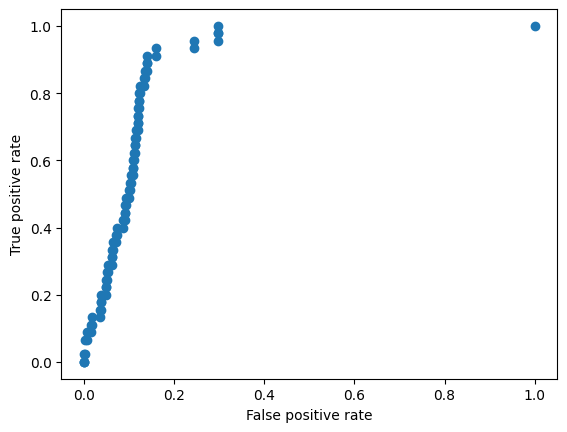

In [20]:
fpr, tpr, thresholds=roc_curve(ground_truth, kw_probs)
plt.scatter(fpr, tpr)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [21]:
# taken from https://yangcha.github.io/EER-ROC/ on 18 Apr 2025
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
eer, thresh

(0.13607115821459553, array(0.52232796))

# Put it all together

In [22]:
kw_rows = []

for json_path, tg_path in zip(json_paths, tg_paths):
    print(tg_path)
    with open(json_path, encoding='utf8') as f:
        kws_json = json.load(f)
    keywords = kws_json['keywords']
    timestamps = kws_json['timestamps']
    sim_mat = kws_json['similarity_matrix']
    sim_mat = np.array(sim_mat)

    df = textgrid_to_df(tg_path)

    for i, keyword in enumerate(tqdm(keywords)):
        kw_probs = sim_mat[:,i]
        ground_truth = timestamp_hits(df, keyword, timestamps)
        if not ground_truth.sum():
            # tqdm.write("keyword not found, skipping...")
            continue
        # tqdm.write(keyword)
        fpr, tpr, thresholds=roc_curve(ground_truth, kw_probs)

        eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        thresh = interp1d(fpr, thresholds)(eer).item()
        # tqdm.write(f"{eer=:.2f}\t{thresh=:.2f}")

        kw_rows.append({'keyword': keyword, 'eer': eer, 'threshold': thresh})
kw_df = pd.DataFrame(kw_rows)
kw_df.head()

C:\projects\malachor5\data\tira_eval_mfa_aligned\HH20210312.TextGrid


100%|██████████| 18/18 [01:12<00:00,  4.01s/it]


C:\projects\malachor5\data\tira_eval_mfa_aligned\HH20210913.TextGrid


100%|██████████| 23/23 [01:57<00:00,  5.12s/it]


C:\projects\malachor5\data\tira_eval_mfa_aligned\HH20220327-2.TextGrid


100%|██████████| 60/60 [05:05<00:00,  5.10s/it]


,keyword,eer,threshold
0,làŋə̀l və́lɛ̂ðɛ̀,0.136071,0.522328
1,a ló,0.577552,0.142707
2,laŋ,0.186937,0.297374
3,jɛ jə,0.176305,0.287465
4,lâlló və́lɛ̀ðɔ́,0.085677,0.571142


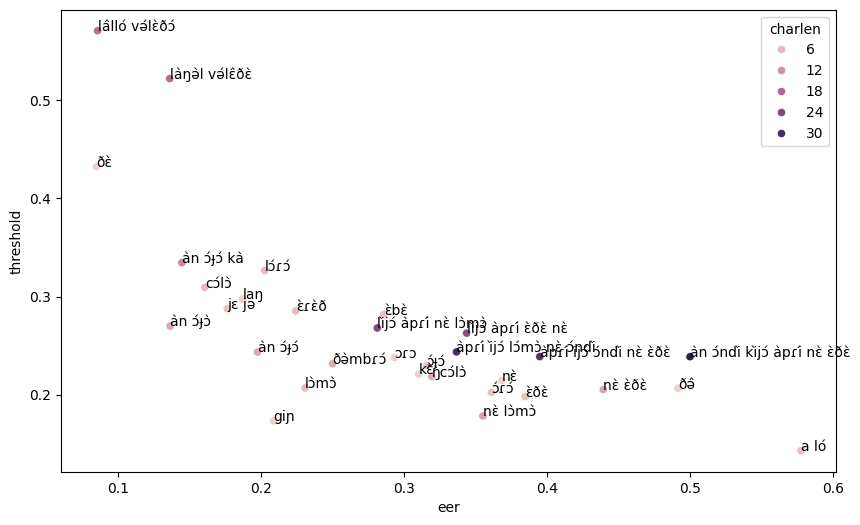

In [23]:
plt.figure(figsize=(10, 6))
kw_df['charlen']=kw_df['keyword'].str.len()
fig=sns.scatterplot(kw_df, x='eer', y='threshold', hue='charlen')
# fig.set_xlim(0,1)
# fig.set_ylim(0,1)
for _, row in kw_df.iterrows():
    plt.text(row['eer'], row['threshold'], row['keyword'])
plt.show()

# Inference w/in 10s window
Let's do the same but instead see what EER we obtain using the max similarity w/in a 10sec window (since this is closer to the actual inference case).

First create a list of timestamps with window length 10s and shift 2s, then using the similarity matrix get the maximum cosine similarity for the domain of the longer window.

In [24]:
timestamps[-1]

{'start_s': 3125.0, 'end_s': 3126.5965}

In [25]:
kw_10sec_rows = []

for json_path, tg_path in zip(json_paths, tg_paths):
    print(tg_path)
    with open(json_path, encoding='utf8') as f:
        kws_json = json.load(f)
    keywords = kws_json['keywords']
    timestamps_2s = kws_json['timestamps']
    max_time = timestamps_2s[-1]['end']
    timestamps_10s = get_sliding_window()

    sim_mat = kws_json['similarity_matrix']
    sim_mat = np.array(sim_mat)

    df = textgrid_to_df(tg_path)

    for i, keyword in enumerate(tqdm(keywords)):
        kw_probs = sim_mat[:,i]
        ground_truth = timestamp_hits(df, keyword, timestamps)
        if not ground_truth.sum():
            # tqdm.write("keyword not found, skipping...")
            continue
        # tqdm.write(keyword)
        fpr, tpr, thresholds=roc_curve(ground_truth, kw_probs)

        eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        thresh = interp1d(fpr, thresholds)(eer).item()
        # tqdm.write(f"{eer=:.2f}\t{thresh=:.2f}")

        kw_10sec_rows.append({'keyword': keyword, 'eer': eer, 'threshold': thresh})
kw_10sec_df = pd.DataFrame(kw_10sec_rows)
kw_10sec_df.head()

C:\projects\malachor5\data\tira_eval_mfa_aligned\HH20210312.TextGrid


KeyError: 'end'